Steps:
1. Correlation of currencies to be hedged and their respective MSCI Index
2. Check performance of partially hedged portfolios w/o export-heavy indicies
3. Check which drivers are most influencing the outperformance of a fully hedged portfolio -> Johnson Relative Weights
4. Plots: (a) Correlations, (b) Returns, (c) Relative Weights

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.formula.api import ols

In [28]:
# Daily Data

# Paths
currencies = "Data/FX_CHF_ALL_1971-2020.xlsx"
msci_all_local = "Data/MSCI_ALL_LOCAL.xlsx"

# FX
df_fx_indirect = pd.read_excel(currencies, header=0, index_col=0, sheet_name="Sheet1")
df_fx_direct = 1 / df_fx_indirect
df_fx_direct = df_fx_direct.replace([np.inf, -np.inf], np.nan)
df_fx_direct.columns = ['USDCHF', 'EURCHF', 'GBPCHF', 'AUDCHF', 'JPYCHF', 'CADCHF']

# MSCI
df_msci_all_local = pd.read_excel(msci_all_local, header=3, index_col=0, sheet_name="CleanTimeSeries")
df_msci_all_local = df_msci_all_local.sort_index()

# Monthly Data

# Paths
msci_all_local_m = "Data/MSCI_ALL_LOCAL_MONTHLY.xlsx"

# FX
df_fx_direct_m = df_fx_direct.resample('M').last()

# MSCI
df_msci_all_local_m = pd.read_excel(msci_all_local_m, header=0, index_col=0).sort_index()

# Quarterly Data

# Paths

# FX
df_fx_direct_q = df_fx_direct.resample('Q').last()

# MSCI
df_msci_all_local_q = df_msci_all_local.resample('Q').last()

In [20]:
# Daily

# Drop columns with NA
df_msci_all_local = df_msci_all_local[df_msci_all_local!=0].dropna()
df_msci_all_local = df_msci_all_local.replace([np.inf, -np.inf], np.nan)

# Drop SZ und WI index
df_msci_all_local = df_msci_all_local.drop(['MSDLSZ Index', 'MSDLWI Index'], axis = 1)

# Combine with FX rate data
df_msci_all_local_ret = np.log(df_msci_all_local.sort_index()).diff()
df_fx_direct_ret = np.log(df_fx_direct.sort_index()).diff()

# Combine the df
df_msci_all_local_fx_ret = pd.concat([df_msci_all_local_ret, df_fx_direct_ret], axis=1, join="inner")
df_msci_all_local_fx_ret = df_msci_all_local_fx_ret[df_msci_all_local_fx_ret!=0].dropna()

In [21]:
# Monthly

# Drop columns with NA
df_msci_all_local_m = df_msci_all_local_m[df_msci_all_local_m!=0].dropna()
df_msci_all_local_m = df_msci_all_local_m.replace([np.inf, -np.inf], np.nan)

# Drop SZ und WI index
df_msci_all_local_m = df_msci_all_local_m.drop(['MSDLSZ Index', 'MSDLWI Index'], axis = 1)

# Combine with FX rate data
df_msci_all_local_ret_m = np.log(df_msci_all_local_m.sort_index()).diff()
df_fx_direct_ret_m = np.log(df_fx_direct_m.sort_index()).diff()

# Combine the df
df_msci_all_local_fx_ret_m = pd.concat([df_msci_all_local_ret_m, df_fx_direct_ret_m], axis=1, join="inner")
df_msci_all_local_fx_ret_m = df_msci_all_local_fx_ret_m[df_msci_all_local_fx_ret_m!=0].dropna()

In [29]:
# Quartely

# Drop columns with NA
df_msci_all_local_q = df_msci_all_local_q[df_msci_all_local_q!=0].dropna()
df_msci_all_local_q = df_msci_all_local_q.replace([np.inf, -np.inf], np.nan)

# Drop SZ und WI index
df_msci_all_local_q = df_msci_all_local_q.drop(['MSDLSZ Index', 'MSDLWI Index'], axis = 1)

# Combine with FX rate data
df_msci_all_local_ret_q = np.log(df_msci_all_local_q.sort_index()).diff()
df_fx_direct_ret_q = np.log(df_fx_direct_q.sort_index()).diff()

# Combine the df
df_msci_all_local_fx_ret_q = pd.concat([df_msci_all_local_ret_q, df_fx_direct_ret_q], axis=1, join="inner")
df_msci_all_local_fx_ret_q = df_msci_all_local_fx_ret_q[df_msci_all_local_fx_ret_q!=0].dropna()

In [30]:
df_msci_all_local_fx_ret_q.corr()

,MSDLE15 Index,MSDLAS Index,MSDLCA Index,MSDLJN Index,MSDLUK Index,MXUS Index,USDCHF,EURCHF,GBPCHF,AUDCHF,JPYCHF,CADCHF
MSDLE15 Index,1.000000,0.878670,0.860669,0.735053,0.945852,0.920042,0.012131,0.182001,0.295695,0.570460,-0.299416,0.429477
MSDLAS Index,0.878670,1.000000,0.843445,0.706529,0.864862,0.828029,0.033169,0.217918,0.319844,0.603837,-0.292498,0.469123
MSDLCA Index,0.860669,0.843445,1.000000,0.699976,0.835523,0.861948,-0.068414,0.279423,0.404794,0.673693,-0.348565,0.444618
MSDLJN Index,0.735053,0.706529,0.699976,1.000000,0.660059,0.721653,0.098132,0.187746,0.415237,0.441272,-0.486056,0.380309
MSDLUK Index,0.945852,0.864862,0.835523,0.660059,1.000000,0.877826,-0.041578,0.193172,0.165301,0.568293,-0.254754,0.407846
MXUS Index,0.920042,0.828029,0.861948,0.721653,0.877826,1.000000,-0.040391,0.277116,0.368339,0.615721,-0.337008,0.474310
USDCHF,0.012131,0.033169,-0.068414,0.098132,-0.041578,-0.040391,1.000000,0.162847,0.463516,0.280600,0.354973,0.603784
EURCHF,0.182001,0.217918,0.279423,0.187746,0.193172,0.277116,0.162847,1.000000,0.519361,0.460568,-0.069903,0.483788
GBPCHF,0.295695,0.319844,0.404794,0.415237,0.165301,0.368339,0.463516,0.519361,1.000000,0.565385,-0.087916,0.628160
AUDCHF,0.570460,0.603837,0.673693,0.441272,0.568293,0.615721,0.280600,0.460568,0.565385,1.000000,0.010731,0.714409


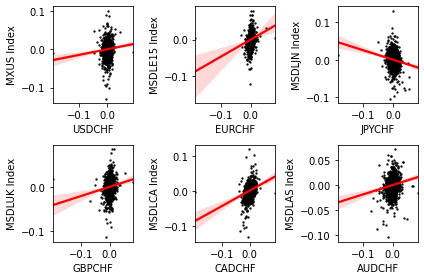

In [25]:
fig, axs = plt.subplots(ncols = 3, nrows = 2)
sns.regplot(x='USDCHF', y='MXUS Index', data=df_msci_all_local_fx_ret, ax=axs[0,0],
            scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='EURCHF', y='MSDLE15 Index', data=df_msci_all_local_fx_ret, ax=axs[0,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='JPYCHF', y='MSDLJN Index', data=df_msci_all_local_fx_ret, ax=axs[0,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='GBPCHF', y='MSDLUK Index', data=df_msci_all_local_fx_ret, ax=axs[1,0],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='CADCHF', y='MSDLCA Index', data=df_msci_all_local_fx_ret, ax=axs[1,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='AUDCHF', y='MSDLAS Index', data=df_msci_all_local_fx_ret, ax=axs[1,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
plt.tight_layout()

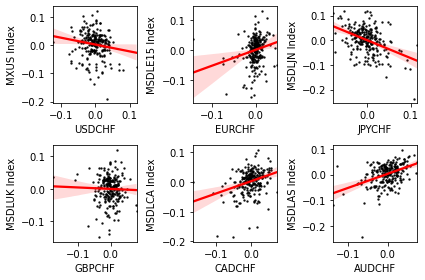

In [26]:
fig, axs = plt.subplots(ncols = 3, nrows = 2)
sns.regplot(x='USDCHF', y='MXUS Index', data=df_msci_all_local_fx_ret_m, ax=axs[0,0],
            scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='EURCHF', y='MSDLE15 Index', data=df_msci_all_local_fx_ret_m, ax=axs[0,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='JPYCHF', y='MSDLJN Index', data=df_msci_all_local_fx_ret_m, ax=axs[0,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='GBPCHF', y='MSDLUK Index', data=df_msci_all_local_fx_ret_m, ax=axs[1,0],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='CADCHF', y='MSDLCA Index', data=df_msci_all_local_fx_ret_m, ax=axs[1,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='AUDCHF', y='MSDLAS Index', data=df_msci_all_local_fx_ret_m, ax=axs[1,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
plt.tight_layout()

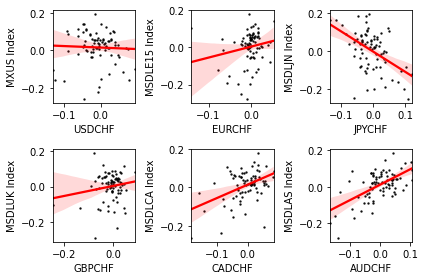

In [31]:
fig, axs = plt.subplots(ncols = 3, nrows = 2)
sns.regplot(x='USDCHF', y='MXUS Index', data=df_msci_all_local_fx_ret_q, ax=axs[0,0],
            scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='EURCHF', y='MSDLE15 Index', data=df_msci_all_local_fx_ret_q, ax=axs[0,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='JPYCHF', y='MSDLJN Index', data=df_msci_all_local_fx_ret_q, ax=axs[0,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='GBPCHF', y='MSDLUK Index', data=df_msci_all_local_fx_ret_q, ax=axs[1,0],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='CADCHF', y='MSDLCA Index', data=df_msci_all_local_fx_ret_q, ax=axs[1,1],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
sns.regplot(x='AUDCHF', y='MSDLAS Index', data=df_msci_all_local_fx_ret_q, ax=axs[1,2],
           scatter_kws={"color": "black", 's':2}, line_kws={"color": "red"})
plt.tight_layout()

Only JPN Index returns the respective FX rate retruns seem to be negatively correlated throughout daily, monthly and quartely frequency. That means the lower the FX return, meaning a depreciation of the forgein currency (denominator is CHF), the higher the MSCI Index return. This is as Nicola expected for export heavy countries like Japan. A natural hedge exists. Does this affect the hedge ratio?